# Author Information 

**Student name**: Milad Shirani

**Student pace**: self paced

**Scheduled project review date/time**: August, 3, 2022 at 12:30 PM Pacific Time.

**Instructor name**: Claude Fried

**Github**: https://github.com/miladshiraniUCB/Emotion-Detection-in-Speech.git

# Introduction

In this section, we will use the spectrograms made in the EDA notebook to train CNN models and we will present different models including transfer learning.

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [5]:
!nvidia-smi

Mon Aug  8 22:03:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Functions

The function `loss_acc` is defined to take the model and returns the loss and accuracy diagrams of the model.

In [17]:
def loss_acc(model):


    fig , ax = plt.subplots(1,2)


    test_acc = model.history.history["val_accuracy"]
    test_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    train_loss = model.history.history["loss"]

    epochs = range(1, len(test_acc) + 1)

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()


In [55]:
def extract_features(directory, sample_amount, transfer, out_size, batch_size = 30, n_class = 7):
    features = np.zeros(shape=(sample_amount, out_size)) 
    labels = np.zeros(shape=(sample_amount, n_class))
    generator = datagen.flow_from_directory(
                                            directory, 
                                            target_size = target_size, 
                                            batch_size  = batch_size, 
                                            class_mode  ='categorical')
    # i=0
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = transfer.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [11]:
# def classification(model, data):

#   pred = model.predict_generator(data)
#   prediction = pred > 0.5

#   print(data.class_indices)
#   print(classification_report(data.classes, prediction))


# Importing Train-Test data sets

In [20]:
base_dir = "/content/drive/MyDrive/Emotion-Detection/mel_spectrogram"

train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Directory with training normal/abnormal spectrograms
train_angry    = os.path.join(train_dir, 'angry')
train_disgust  = os.path.join(train_dir, 'disgust')
train_fear     = os.path.join(train_dir, 'fear')
train_happy    = os.path.join(train_dir, 'happy')
train_neutral  = os.path.join(train_dir, 'neutral')
train_sad      = os.path.join(train_dir, 'sad')
train_surprise = os.path.join(train_dir, 'surprise')


# Directory with test normal/abnormal spectrograms

test_angry    = os.path.join(test_dir, 'angry')
test_disgust  = os.path.join(test_dir, 'disgust')
test_fear     = os.path.join(test_dir, 'fear')
test_happy    = os.path.join(test_dir, 'happy')
test_neutral  = os.path.join(test_dir, 'neutral')
test_sad      = os.path.join(test_dir, 'sad')
test_surprise = os.path.join(test_dir, 'surprise')


In [21]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=30,
                                                    class_mode="categorical",
                                                    target_size=target_size)     

validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = "categorical",
                                                         target_size = target_size)

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


# Modeling

In this section, we will present some CNN based models and we will use some transfer learning models to be used in this work.

## Convolutional Neural Network

In this section, we will present the CNN based models. As we can see all of the models perform well with the test accuracy around 99%.

### First Model

In [22]:
model_1 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 87616)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                5607488   
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 5,608,391
Trainable params: 5,608,391
Non-trainable params: 0
____________________________________________

In [23]:
model_1.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_1.fit_generator(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 94s 1s/step - loss: 0.6259 - accuracy: 0.8214 - val_loss: 0.0722 - val_accuracy: 0.9786
Epoch 2/10
75/75 [==============================] - 94s 1s/step - loss: 0.0222 - accuracy: 0.9978 - val_loss: 0.0243 - val_accuracy: 0.9946
Epoch 3/10
75/75 [==============================] - 94s 1s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9982
Epoch 4/10
75/75 [==============================] - 93s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 93s 1s/step - loss: 8.6227e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 6/10
75/75 [==============================] - 93s 1s/step - loss: 4.7626e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 92s 1s/step - loss: 3.0942e-04 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 8/

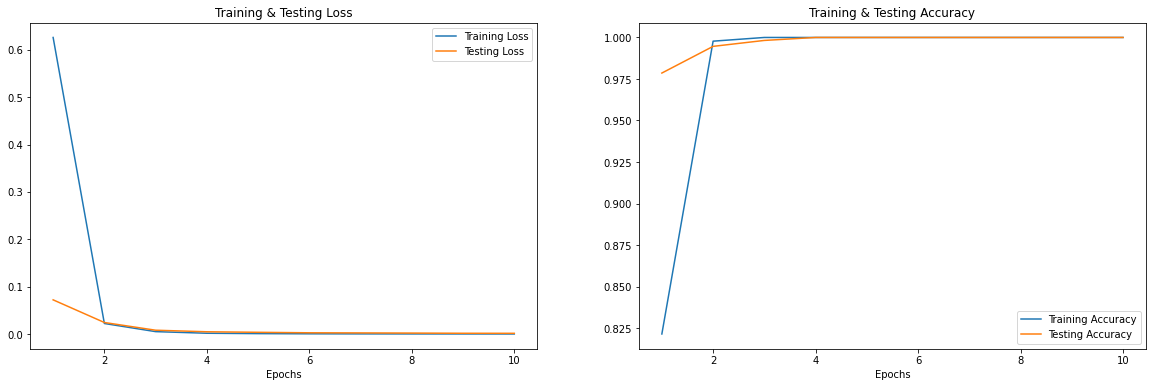

In [24]:
loss_acc(model_1)

### Second Model

In [25]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')   
])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 64)      

In [26]:
model_2.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_2.fit_generator(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 94s 1s/step - loss: 0.8180 - accuracy: 0.7241 - val_loss: 0.1036 - val_accuracy: 0.9661
Epoch 2/10
75/75 [==============================] - 94s 1s/step - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.0239 - val_accuracy: 0.9964
Epoch 3/10
75/75 [==============================] - 95s 1s/step - loss: 0.0071 - accuracy: 0.9987 - val_loss: 0.0039 - val_accuracy: 0.9982
Epoch 4/10
75/75 [==============================] - 94s 1s/step - loss: 2.0548e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9982
Epoch 5/10
75/75 [==============================] - 94s 1s/step - loss: 1.1213e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9982
Epoch 6/10
75/75 [==============================] - 94s 1s/step - loss: 7.8411e-05 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9982
Epoch 7/10
75/75 [==============================] - 92s 1s/step - loss: 5.8169e-05 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9982
Epoc

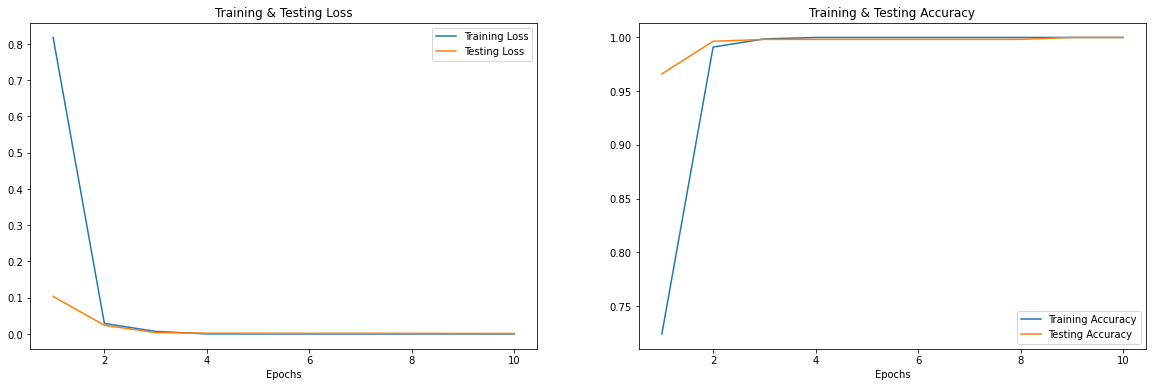

In [27]:
loss_acc(model_2)

### Third Model


In [ ]:
model_3 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
model_3.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_3.fit_generator(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 98s 1s/step - loss: 1.3414 - accuracy: 0.6089 - val_loss: 0.5181 - val_accuracy: 0.8982
Epoch 2/10
75/75 [==============================] - 98s 1s/step - loss: 0.2679 - accuracy: 0.9527 - val_loss: 0.1200 - val_accuracy: 0.9804
Epoch 3/10
75/75 [==============================] - 99s 1s/step - loss: 0.0874 - accuracy: 0.9835 - val_loss: 0.0748 - val_accuracy: 0.9839
Epoch 4/10
75/75 [==============================] - 99s 1s/step - loss: 0.0425 - accuracy: 0.9933 - val_loss: 0.0389 - val_accuracy: 0.9911
Epoch 5/10
75/75 [==============================] - 98s 1s/step - loss: 0.0247 - accuracy: 0.9982 - val_loss: 0.0402 - val_accuracy: 0.9839
Epoch 6/10
75/75 [==============================] - 96s 1s/step - loss: 0.0158 - accuracy: 0.9991 - val_loss: 0.0282 - val_accuracy: 0.9964
Epoch 7/10
75/75 [==============================] - 96s 1s/step - loss: 0.0096 - accuracy: 0.9996 - val_loss: 0.0195 - val_accuracy: 0.9929
Epoch 8/10
75/75 [==

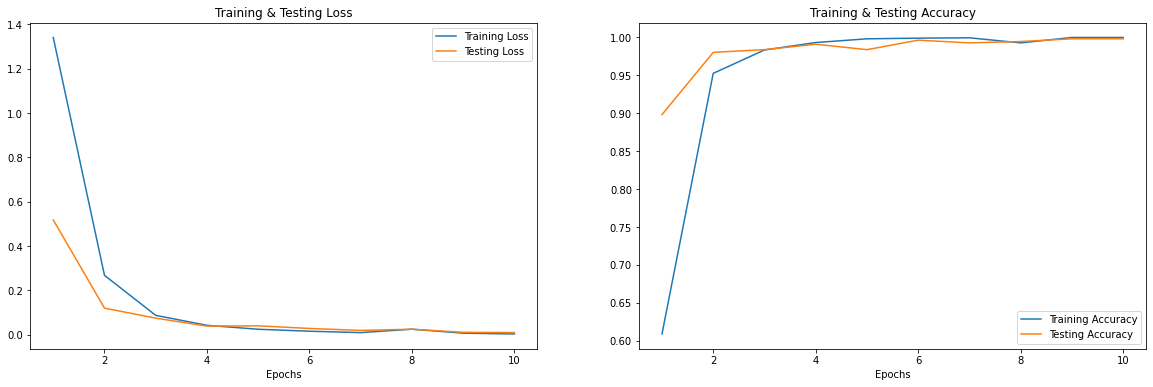

In [ ]:
loss_acc(model_3)

### Forth Model

In [28]:
model_4 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 64)      

In [29]:
model_4.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_4.fit_generator(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 98s 1s/step - loss: 1.0419 - accuracy: 0.6009 - val_loss: 0.5588 - val_accuracy: 0.8232
Epoch 2/10
75/75 [==============================] - 95s 1s/step - loss: 0.1623 - accuracy: 0.9438 - val_loss: 0.0377 - val_accuracy: 0.9839
Epoch 3/10
75/75 [==============================] - 94s 1s/step - loss: 0.0436 - accuracy: 0.9835 - val_loss: 0.0440 - val_accuracy: 0.9804
Epoch 4/10
75/75 [==============================] - 94s 1s/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0082 - val_accuracy: 0.9964
Epoch 5/10
75/75 [==============================] - 94s 1s/step - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.0110 - val_accuracy: 0.9982
Epoch 6/10
75/75 [==============================] - 93s 1s/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 93s 1s/step - loss: 3.0228e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 8/10
75/75

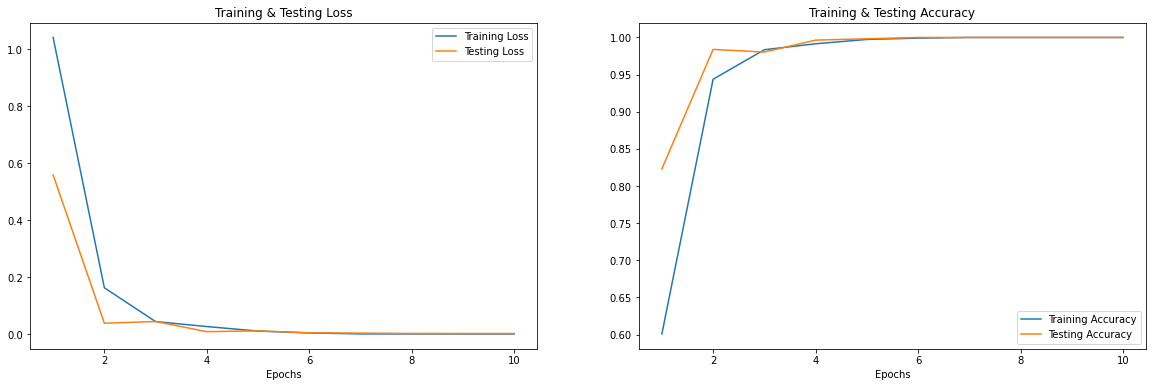

In [30]:
loss_acc(model_4)

## Fifth Model

In [31]:
model_5 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

In [32]:
model_5.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_5.fit_generator(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 96s 1s/step - loss: 1.3712 - accuracy: 0.4723 - val_loss: 0.5640 - val_accuracy: 0.8125
Epoch 2/10
75/75 [==============================] - 93s 1s/step - loss: 0.3759 - accuracy: 0.8732 - val_loss: 0.2352 - val_accuracy: 0.9143
Epoch 3/10
75/75 [==============================] - 93s 1s/step - loss: 0.1460 - accuracy: 0.9473 - val_loss: 0.1675 - val_accuracy: 0.9286
Epoch 4/10
75/75 [==============================] - 94s 1s/step - loss: 0.0681 - accuracy: 0.9790 - val_loss: 0.0936 - val_accuracy: 0.9625
Epoch 5/10
75/75 [==============================] - 96s 1s/step - loss: 0.0477 - accuracy: 0.9857 - val_loss: 0.0513 - val_accuracy: 0.9804
Epoch 6/10
75/75 [==============================] - 96s 1s/step - loss: 0.0216 - accuracy: 0.9924 - val_loss: 0.0393 - val_accuracy: 0.9857
Epoch 7/10
75/75 [==============================] - 94s 1s/step - loss: 0.0527 - accuracy: 0.9817 - val_loss: 0.0382 - val_accuracy: 0.9821
Epoch 8/10
75/75 [==

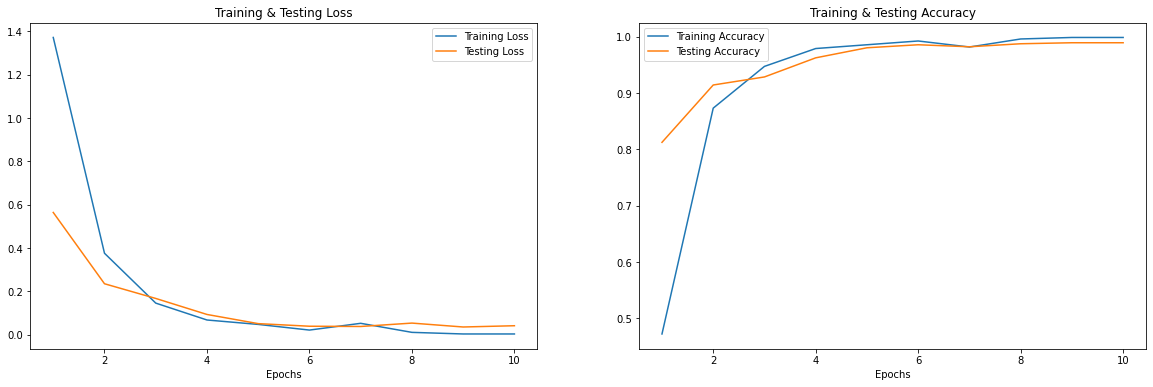

In [34]:
loss_acc(model_5)

## Sixth Model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 17, 17, 64)      

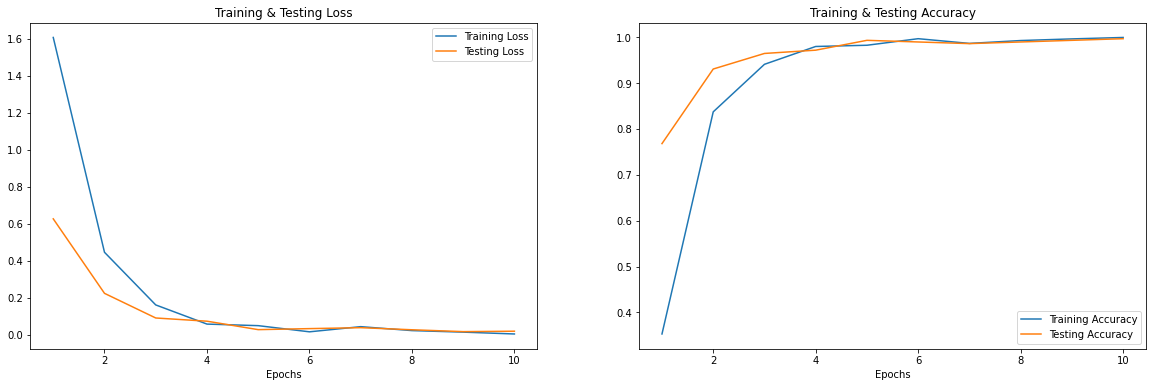

In [36]:
model_6 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_6.summary()


model_6.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_6.fit_generator(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

loss_acc(model_6)

## Transfer Learning

In this section, we will use transfer learning models `EfficientNetB3` and `EfficientNetB7` to train a neural network.

## `EfficientNetB1`

In [52]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



model_name='EfficientNetB1'

efficient_1=tf.keras.applications.EfficientNetB1(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=7,
                                      classifier_activation='softmax',
                                      pooling='max') 

# efficient_1.summary()

In [58]:
# You should be able to divide sample_amount by batch_size
train_features_1, train_labels_1 = extract_features(train_dir, 2240, out_size = 1280, transfer = efficient_1) 
test_features_1, test_labels_1 = extract_features(test_dir, 560, out_size = 1280, transfer = efficient_1)
print("DONE")

eff_model_1 = Sequential()
eff_model_1.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_1.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim=1280))
# eff_model_1.add(Dropout(0.45))
# eff_model_1.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# eff_model_1.add(layers.Dense(256, activation='relu'))
# eff_model_1.add(Dropout(0.45))
# eff_model_1.add(layers.Dense(128, activation='relu'))
# eff_model_1.add(Dropout(0.45))

eff_model_1.add(layers.Dense(7, activation='softmax'))

eff_model_1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_1.fit(train_features_1, train_labels_1,
                    epochs=100,
                    batch_size=30,
                    verbose = 0,
                    validation_data=(test_features_1, test_labels_1))
print("Fitting Done")

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.
DONE
Fitting Done


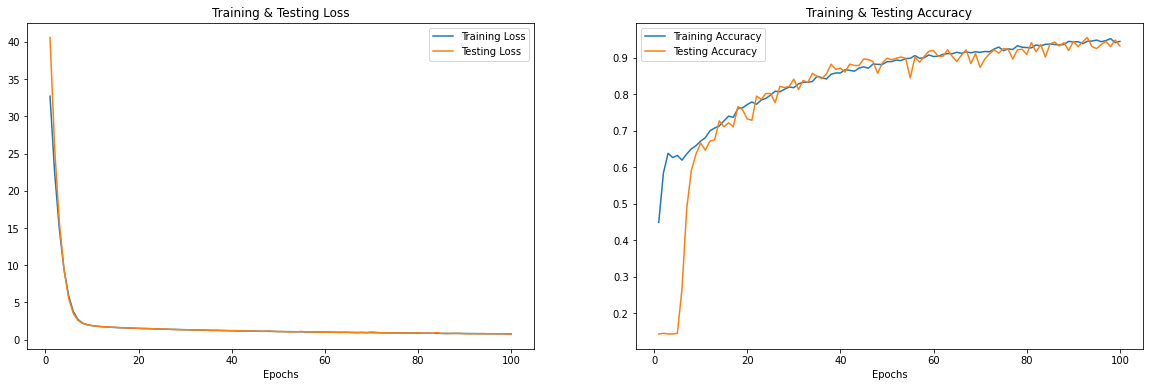

In [59]:
loss_acc(eff_model_1)

## `EfficientNetB2`

In [61]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



model_name='EfficientNetB2'

efficient_2=tf.keras.applications.EfficientNetB2(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=7,
                                      classifier_activation='softmax',
                                      pooling='max') 

# efficient_2.summary()

In [63]:
# You should be able to divide sample_amount by batch_size
train_features_2, train_labels_2 = extract_features(train_dir, 2240, 
                                                    out_size = 1408, 
                                                    transfer = efficient_2) 
test_features_2, test_labels_2 = extract_features(test_dir, 560, 
                                                  out_size = 1408, 
                                                  transfer = efficient_2)
print("DONE")

eff_model_2 = Sequential()
eff_model_2.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_2.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim=1408))
# eff_model_2.add(Dropout(0.45))
# eff_model_2.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# eff_model_2.add(layers.Dense(256, activation='relu'))
# eff_model_2.add(Dropout(0.45))
# eff_model_2.add(layers.Dense(128, activation='relu'))
# eff_model_2.add(Dropout(0.45))

eff_model_2.add(layers.Dense(7, activation='softmax'))

eff_model_2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_2.fit(train_features_1, train_labels_1,
                    epochs=100,
                    batch_size=30,
                    verbose = 0,
                    validation_data=(test_features_1, test_labels_1))
print("Fitting Done")

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.
DONE
Fitting Done


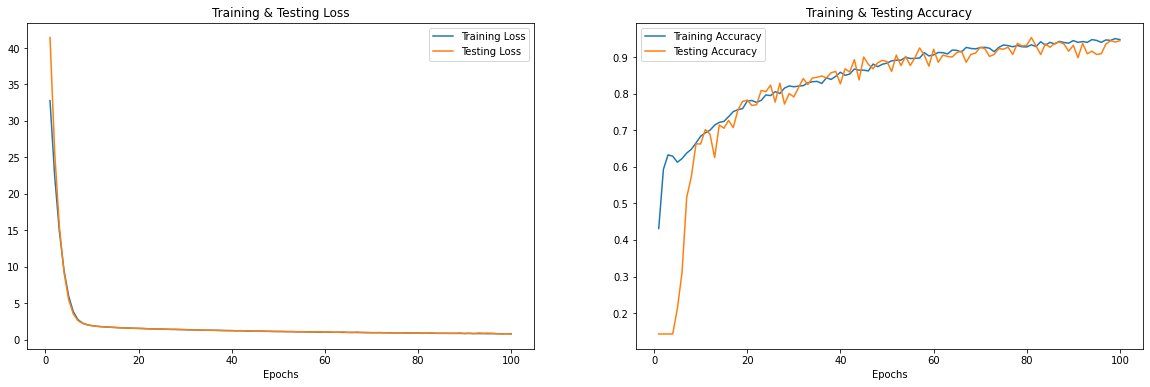

In [64]:
loss_acc(eff_model_2)

### `EfficientNetB3`

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=50,
                                                    class_mode="categorical",
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=25,
                                                         class_mode  = "categorical",
                                                         target_size = target_size)



Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [ ]:
model_name='EfficientNetB3'
efficient_model=tf.keras.applications.EfficientNetB3(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=(target_size[0], target_size[1], 3),
                                      pooling='max') 

x=efficient_model.output

x=tf.keras.layers.BatchNormalization(axis=-1, 
                                  momentum=0.99,
                                  epsilon=0.001 )(x)

x = Dense(256, 
          kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
          activity_regularizer = tf.keras.regularizers.l1(0.05),
          bias_regularizer     = tf.keras.regularizers.l1(0.05),
          activation='relu')(x)
          
x=tf.keras.layers.Dropout(rate=.45, seed=123)(x)  

output=Dense(7, activation='softmax')(x)

eff_model=tf.keras.models.Model(inputs=efficient_model.input, outputs=output)

eff_model.compile(tf.keras.optimizers.Adamax(learning_rate=.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

# eff_model.summary()

In [ ]:
eff_model.fit(
            train_generator,
            epochs=25,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/25
45/45 [==============================] - 112s 2s/step - loss: 22.1103 - accuracy: 0.7415 - val_loss: 17.6656 - val_accuracy: 0.1429
Epoch 2/25
45/45 [==============================] - 94s 2s/step - loss: 13.3407 - accuracy: 0.9580 - val_loss: 12.4169 - val_accuracy: 0.1429
Epoch 3/25
45/45 [==============================] - 94s 2s/step - loss: 9.3593 - accuracy: 0.9781 - val_loss: 8.9780 - val_accuracy: 0.1429
Epoch 4/25
45/45 [==============================] - 97s 2s/step - loss: 6.6729 - accuracy: 0.9915 - val_loss: 6.7828 - val_accuracy: 0.1429
Epoch 5/25
45/45 [==============================] - 104s 2s/step - loss: 4.8382 - accuracy: 0.9960 - val_loss: 5.3822 - val_accuracy: 0.1429
Epoch 6/25
45/45 [==============================] - 102s 2s/step - loss: 3.5955 - accuracy: 0.9951 - val_loss: 4.4163 - val_accuracy: 0.1429
Epoch 7/25
45/45 [==============================] - 98s 2s/step - loss: 2.7382 - accuracy: 0.9978 - val_loss: 3.6858 - val_accuracy: 0.1571
Epoch 8/25
45

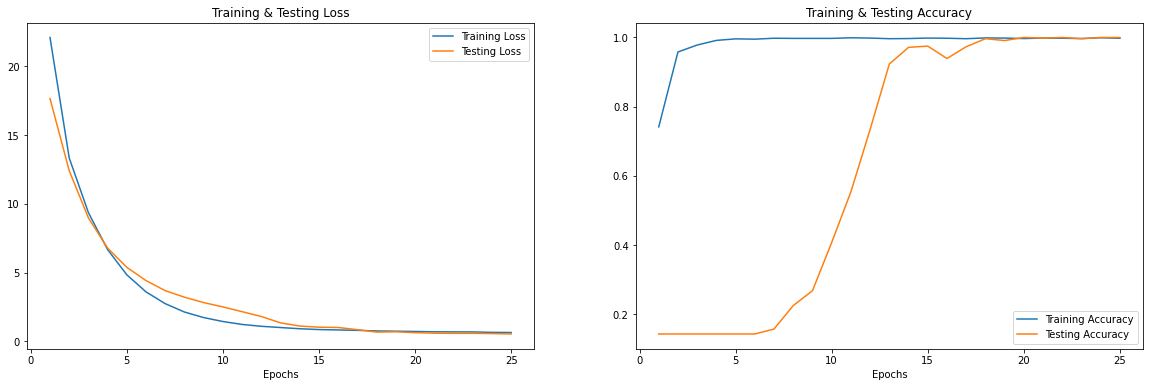

In [ ]:
loss_acc(eff_model)

## `EfficientNetB4`

In [67]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



model_name='EfficientNetB4'

efficient_4=tf.keras.applications.EfficientNetB4(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=7,
                                      classifier_activation='softmax',
                                      pooling='max') 

# efficient_4.summary()

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.
DONE
Fitting Done


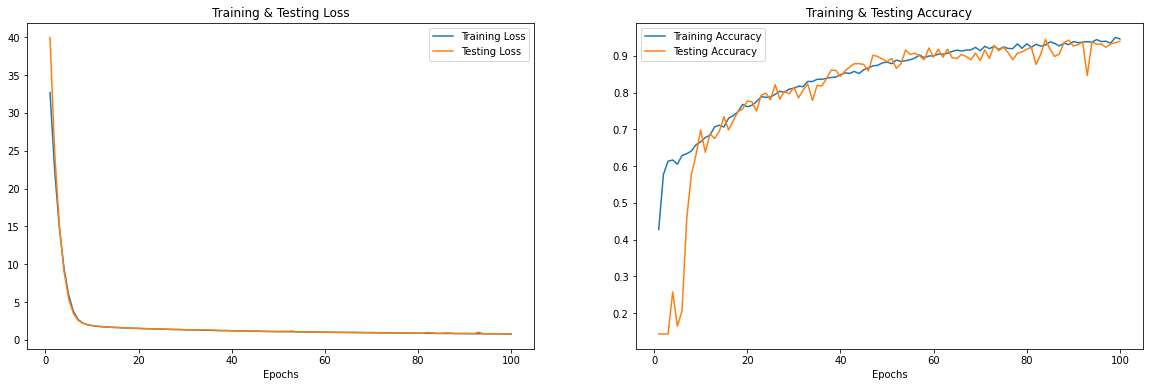

In [66]:
out_size = 1792
train_features_4, train_labels_4 = extract_features(train_dir, 2240, 
                                                    out_size = out_size, 
                                                    transfer = efficient_4) 
test_features_4, test_labels_4 = extract_features(test_dir, 560, 
                                                  out_size = out_size, 
                                                  transfer = efficient_4)
print("DONE")

eff_model_4 = Sequential()
eff_model_4.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_4.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim = out_size))
# eff_model_4.add(Dropout(0.45))
# eff_model_4.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# eff_model_4.add(layers.Dense(256, activation='relu'))
# eff_model_4.add(Dropout(0.45))
# eff_model_4.add(layers.Dense(128, activation='relu'))
# eff_model_4.add(Dropout(0.45))

eff_model_4.add(layers.Dense(7, activation='softmax'))

eff_model_4.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_4.fit(train_features_4, train_labels_4,
                    epochs=100,
                    batch_size=30,
                    verbose = 0,
                    validation_data=(test_features_4, test_labels_4))
print("Fitting Done")

loss_acc(eff_model_4)

## `EfficientNetB5`

In [70]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



model_name='EfficientNetB4'

efficient_5=tf.keras.applications.EfficientNetB5(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=7,
                                      classifier_activation='softmax',
                                      pooling='max') 

# efficient_5.summary()

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.
DONE
Fitting Done


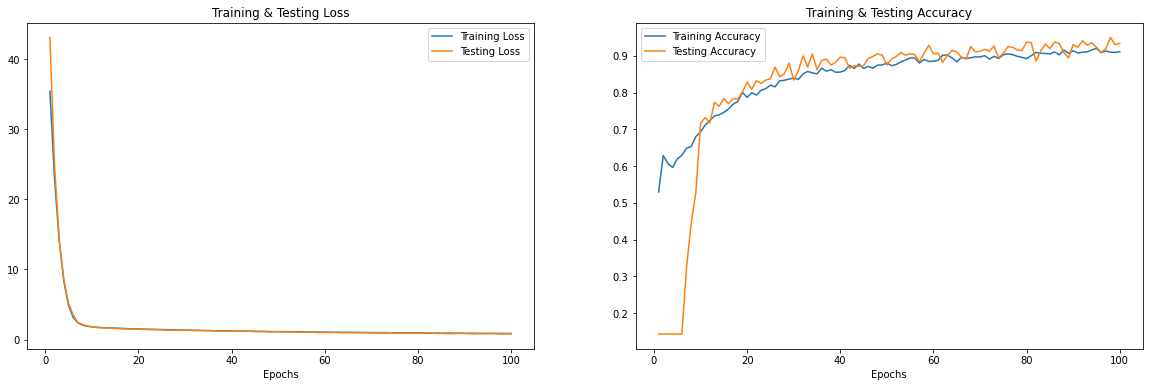

In [69]:
out_size = 2048
train_features_5, train_labels_5 = extract_features(train_dir, 2240, 
                                                    out_size = out_size, 
                                                    transfer = efficient_5) 
test_features_5, test_labels_5 = extract_features(test_dir, 560, 
                                                  out_size = out_size, 
                                                  transfer = efficient_5)
print("DONE")

eff_model_5 = Sequential()
eff_model_5.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_5.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim = out_size))
# eff_model_5.add(Dropout(0.45))
# eff_model_5.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# eff_model_5.add(layers.Dense(256, activation='relu'))
# eff_model_5.add(Dropout(0.45))
# eff_model_5.add(layers.Dense(128, activation='relu'))
# eff_model_5.add(Dropout(0.45))

eff_model_5.add(layers.Dense(7, activation='softmax'))

eff_model_5.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_5.fit(train_features_5, train_labels_5,
                    epochs=100,
                    batch_size=30,
                    verbose = 0,
                    validation_data=(test_features_5, test_labels_5))
print("Fitting Done")

loss_acc(eff_model_5)

### `EfficientNetB6`

In [71]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



model_name='EfficientNetB6'

efficient_6=tf.keras.applications.EfficientNetB6(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=7,
                                      classifier_activation='softmax',
                                      pooling='max') 

efficient_6.summary()

165249024/165234480 [==============================] - 1s 0us/step
Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_9 (Rescaling)        (None, 150, 150, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_9 (Normalization  (None, 150, 150, 3)  7          ['rescaling_9[0][0]']            
 )                                                                                                
                  

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.
DONE
Fitting Done


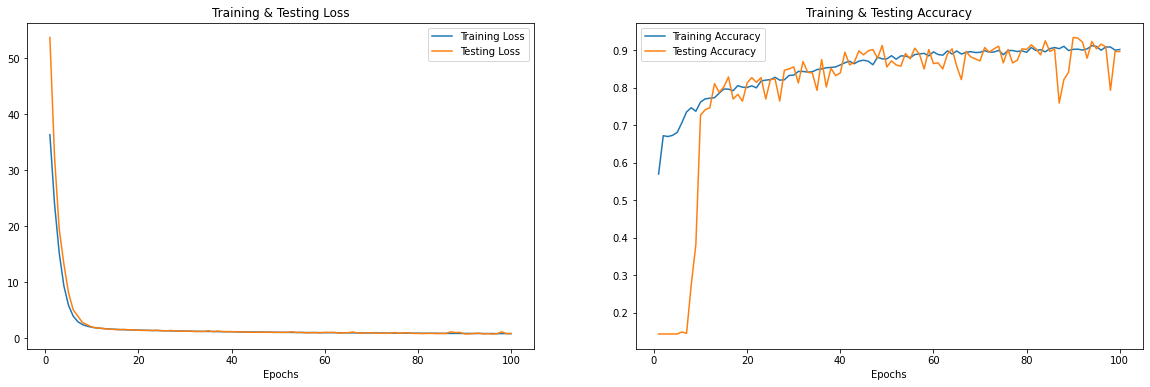

In [72]:
out_size = 2304
train_features_6, train_labels_6 = extract_features(train_dir, 2240, 
                                                    out_size = out_size, 
                                                    transfer = efficient_6) 
test_features_6, test_labels_6 = extract_features(test_dir, 560, 
                                                  out_size = out_size, 
                                                  transfer = efficient_6)
print("DONE")

eff_model_6 = Sequential()
eff_model_6.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_6.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim = out_size))
# eff_model_6.add(Dropout(0.45))
# eff_model_6.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# eff_model_6.add(layers.Dense(256, activation='relu'))
# eff_model_6.add(Dropout(0.45))
# eff_model_6.add(layers.Dense(128, activation='relu'))
# eff_model_6.add(Dropout(0.45))

eff_model_6.add(layers.Dense(7, activation='softmax'))

eff_model_6.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_6.fit(train_features_6, train_labels_6,
                    epochs=100,
                    batch_size=30,
                    verbose = 0,
                    validation_data=(test_features_6, test_labels_6))
print("Fitting Done")

loss_acc(eff_model_6)

### `EfficientNetB7`


In [37]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)

In [38]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



model_name='EfficientNetB7'

efficient_7=tf.keras.applications.EfficientNetB7(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=7,
                                      classifier_activation='softmax',
                                      pooling='max') 

# efficient_7.summary()

258088960/258076736 [==============================] - 1s 0us/step


In [40]:
# You should be able to divide sample_amount by batch_size
train_features, train_labels = extract_features(train_dir, 2240, out_size = 2560, transfer = efficient_7) 
test_features, test_labels = extract_features(test_dir, 560, out_size = 2560, transfer = efficient_7)
print("DONE")

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.
DONE


In [47]:
eff_model_7 = Sequential()
eff_model_7.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_7.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim=2560))
# eff_model_7.add(Dropout(0.45))
# eff_model_7.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# eff_model_7.add(layers.Dense(256, activation='relu'))
# eff_model_7.add(Dropout(0.45))
# eff_model_7.add(layers.Dense(128, activation='relu'))
# eff_model_7.add(Dropout(0.45))

eff_model_7.add(layers.Dense(7, activation='softmax'))

eff_model_7.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_7.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=30,
                    verbose = 0,
                    validation_data=(test_features, test_labels))
print("Fitting Done")

Fitting Done


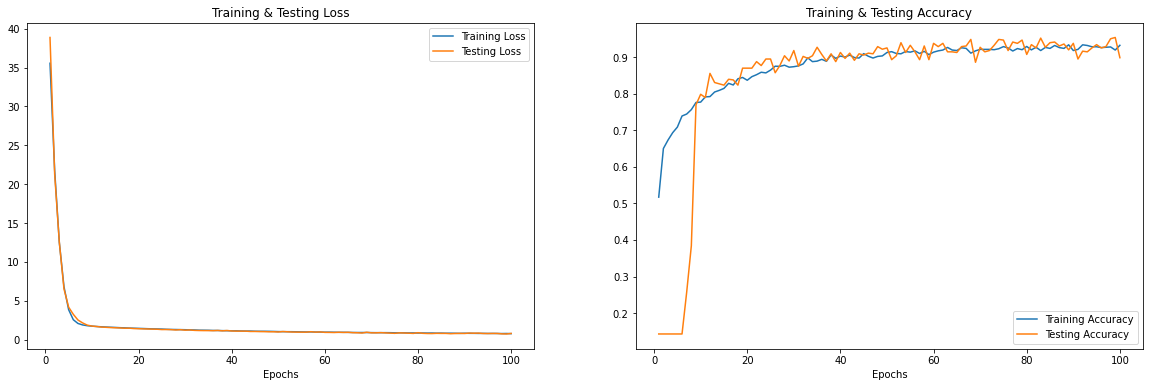

In [48]:
loss_acc(eff_model_7)

# Results and Conclusion

In this notebook, we trained several deep learning models by using convolutional neural network as well as transfer learning. We can see that all models performed well. Therefore, we will use the structure of the model to choose the final model for this work. Since the first model has the simplest structure and it converges after only 2 epochs, we would recommend this model to be used for emotion detection in audio speech. 

For future work, we would recommend obtaining more data for training purposes and also we would recommend using LSTM layers for numerical values obtained from audio files.